In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
import sys
from scipy.optimize import minimize
from tqdm import tqdm
from common import tool_times
from common import well_construction as wc
from common.sensor_types import sensors
from solvers.solver_cim_py.interface import Solver
import torch
import plotly
import plotly.graph_objs as go
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from typing import Tuple
import torch
import torch.optim as optim
from model import Net
model = torch.load('model_weights/modelentire.pth')
model.load_state_dict(torch.load('model_weights/model.pth'))
loss_function = nn.MSELoss()
model.eval()

def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu') # don't have GPU 
    return device

device = get_device()
net = model.double().to(device)

def weighted_mse(u_exp: np.ndarray, u: np.ndarray, time: np.ndarray, eps: float = + 10 ** (-15)) -> Tuple[np.ndarray, np.ndarray]:
    dt = np.diff(time, n=1, axis=0)
    dt = np.append(dt, dt[-1])
    amplitude = np.dot(dt, u * u_exp) / np.dot(dt, u ** 2)
    e = (u_exp - amplitude * u) / (u_exp + eps) * dt
    
    loss = np.dot(e, e)
    return loss



t = 1e-3 * np.array([
    0.135, 0.180, 0.235, 0.315, 0.365, 0.420,
    0.485, 0.560, 0.650, 0.750, 0.865, 1.000,
    1.155, 1.335, 1.540, 1.780, 2.055, 2.370,
    2.740, 3.160, 3.650, 4.215, 4.870, 5.625,
    6.495, 7.500, 8.660, 10.00, 11.55, 13.34,
    15.40, 17.79, 20.54, 23.72, 27.39, 31.63,
    36.52, 42.17, 48.70, 56.24, 64.94, 74.99,
    86.60, 100.0, 115.5, 133.4
])

df = pd.read_pickle('Dataset')
#fix_normed_vector = df.sample(1) временно
fix_normed_vector = df.loc[9030]
fix_normed_vector = pd.DataFrame(fix_normed_vector).transpose()
print ('Зафиксировали произвольный вектор из датафрейма с компонентами \n')
fix_normed_vector

C:\ProgramData\Anaconda3\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


Зафиксировали произвольный вектор из датафрейма с компонентами 



,Sigma,mu,d,th,th0,Decay
9030,-0.809753,-1.56861,0,-0.248755,0,"[0.17439216402987712, 0.15983478220067351, 0.1..."


## Считаем лосс (сигма, мю) через модельную функцию

### Нахождение границ для оптимизатора с учетом параметров усреднения первоначальной выборки

In [2]:
means = np.fromfile('means_scaler')
#print(means)
stds = np.fromfile('stds_scaler')

real_min_sigma = df.describe()['Sigma']['min'] * stds[0] + means[0]
#print ('real min sigma ', min_sigma)

norm_min_sigma =  df.describe()['Sigma']['min'] 
print ('norm min sigma ',norm_min_sigma )

real_max_sigma = df.describe()['Sigma']['max'] * stds[0] + means[0]
#print ('real max sigma ', max_sigma)

norm_max_sigma = df.describe()['Sigma']['max']
print ('norm max sigma ', norm_max_sigma )

real_min_mu = df.describe()['mu']['min'] * stds[1] + means[1]
#print('real min mu ', min_mu)

norm_min_mu = df.describe()['mu']['min']
print ('norm min mu', norm_min_mu)

real_max_mu = df.describe()['mu']['max'] * stds[1] + means[1]
#print ('real max mu ', max_mu)

norm_max_mu = df.describe()['mu']['max']
print ('norm max mu ', norm_max_mu)

#fix_real_vector = df.sample(1)
fix_real_vector = fix_normed_vector[['Sigma', 'mu', 'd', 'th', 'th0']]
fix_real_vector = fix_real_vector*stds+means
fix_real_vector['Decay'] = fix_normed_vector['Decay']
print ('Зафиксировали произвольный вектор из датафрейма с real компонентами \n')
fix_real_vector

norm min sigma  -1.7384717023084395
norm max sigma  1.7400442193406047
norm min mu -1.73281163150911
norm max mu  1.7310589144531967
Зафиксировали произвольный вектор из датафрейма с real компонентами 



,Sigma,mu,d,th,th0,Decay
9030,3.40287e+06,16.6383,89,5.38955,6.5,"[0.17439216402987712, 0.15983478220067351, 0.1..."


### Подсчет и построение тепловых карт лосса с помощью нейросети и модельной функции

In [3]:
def model_decay(d=fix_real_vector.get('d').iloc[0], th0=fix_real_vector.get('th0').iloc[0],
                th=fix_real_vector.get('th').iloc[0], sigma=fix_real_vector.get('Sigma').iloc[0],
                mu=fix_real_vector.get('mu').iloc[0]):
    tubes = [
        wc.Tube(d=(d), th0=(th0), th=(th), sigma=(sigma), mu=(mu)),
    ]

    sensor = sensors.PULSE_3E_1
    times = tool_times.times[sensor]
    solver = Solver(sensor, times, tool_averaging=True, verbose=0)
    output = solver.get_curve(tubes)
    return(output)

def model_loss(real_sigma,real_mu):
    return np.log(weighted_mse(np.array(fix_real_vector.get('Decay').iloc[0]), np.array(model_decay(sigma=real_sigma,
                                                                             mu=real_mu)),t))
def net_loss(norm_sigma, norm_mu):
    tensor = torch.tensor([fix_normed_vector.get('Sigma').iloc[0],norm_sigma,
                           fix_normed_vector.get('mu').iloc[0],norm_mu,
                           fix_normed_vector.get('th').iloc[0],fix_normed_vector.get('th').iloc[0]])
    tensor = tensor.to(device)
    output = net(tensor.double())
    return (output.item())

def l2_norm(norm_sigma, norm_mu):
     return np.linalg.norm([fix_normed_vector.get('Sigma').iloc[0] - norm_sigma,
                          fix_normed_vector.get('mu').iloc[0] - norm_mu])

def model_minimization_function(variable_vector, constant=0.5):
    real_sigma = variable_vector[0]
    real_mu = variable_vector[1]
    norm_sigma = (real_sigma - means[0]) / stds[0]
    norm_mu = (real_mu - means[1]) / stds[1]
    return (-1 * l2_norm(norm_sigma, norm_mu) + constant * model_loss(real_sigma, real_mu))

#### Вычисление и построение карты model_loss and net_loss 

In [4]:
size = 30
sigma_real = np.linspace(real_min_sigma, real_max_sigma, num=size, retstep=True)#sigma
mu_real = np.linspace(real_min_mu, real_max_mu, num=size, retstep=True)#mu
i = 0
j = 0
loss_model = np.zeros((size,size))

In [8]:
import time
startTime = time.time() # время начала замер
for i in tqdm(range(size)):
    while (j < size):
        loss_model[i,j] = model_loss(sigma_real[0][j],mu_real[0][i])
        j = j + 1
    j = 0
endTime = time.time() #время конца замера
totalTime = endTime - startTime #вычисляем затраченное время
print("Время, затраченное на выполнение данного кода = ", totalTime)
loss_model = pd.DataFrame(loss_model)
loss_model.index = np.around(mu_real[0],1) 
loss_model.columns = np.around(sigma_real[0],3)
loss_model.to_pickle('./loss_model_model_matrix.pkl')
#loss_model = pd.read_pickle('./loss_model_model_matrix.pkl')

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [22:40<00:00, 45.34s/it]

Время, затраченное на выполнение данного кода =  1360.157915353775


In [5]:
loss_model = pd.read_pickle('./loss_model_model_matrix.pkl')

In [9]:
i = 0
j = 0
loss_net = np.zeros((size, size))
sigma_norm = (sigma_real[0] - means[0]) / stds[0] 
mu_norm = (mu_real[0] - means[1]) / stds[1]

startTime = time.time() # время начала замер
for i in tqdm(range(size)):
    while (j < size):
        loss_net[i][j] = net_loss(sigma_norm[j], mu_norm[i])
        j += 1
    j = 0
endTime = time.time() #время конца замера
totalTime = endTime - startTime #вычисляем затраченное время

print("Время, затраченное на выполнение данного кода = ", totalTime)
loss_net = pd.DataFrame(loss_net)
loss_net.index = np.around(mu_real[0],1) 
loss_net.columns = np.around(sigma_real[0],3)
loss_net.to_pickle('./loss_net_model_matrix.pkl')
#loss_net = pd.read_pickle('./loss_net_model_matrix.pkl')

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 68.29it/s]

Время, затраченное на выполнение данного кода =  0.4473683834075928


In [6]:
loss_net = pd.read_pickle('./loss_net_model_matrix.pkl')

#### Разница результатов классического и нейросетевого подхода логарифмическая

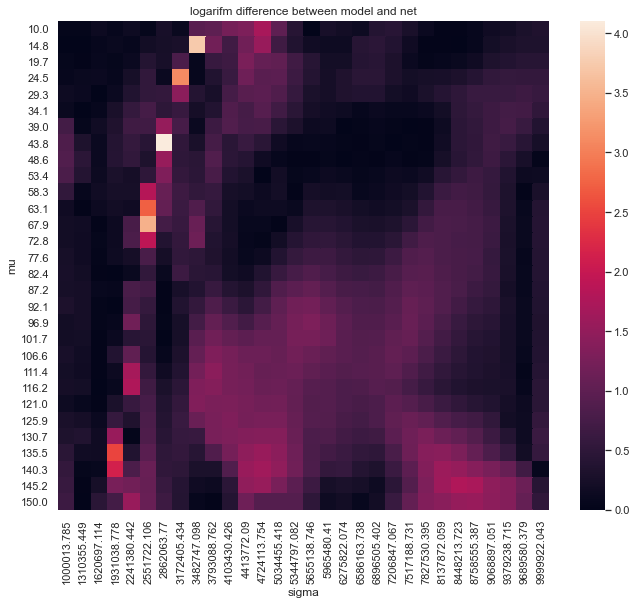

In [7]:
diff = abs(loss_model - loss_net)
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(diff, annot=False, vmin=0)
#name = 'log( loss( (' + str(fix_vector.get('mu').iloc[0])+ ', (' + str(fix_vector.get('Sigma').iloc[0]) + ')))'
name = "logarifm difference between model and net"
ax.set(xlabel='sigma', ylabel='mu', title=name)
# ax = f.gca()
# circle1 = plt.Circle((size/2,size/2), 0.5, color='g', fill=False, label="The zone of the fix vector")
# ax.add_patch(circle1)
# ax.legend()
f.savefig(name + '.png', bbox_inches='tight')

#### Разница результатов классического и нейросетевого подхода реальных данных

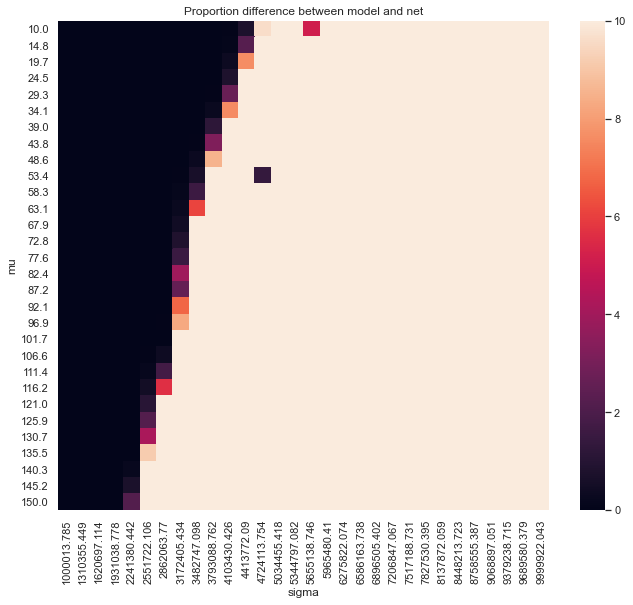

In [12]:
diff = abs(np.exp(loss_model) - np.exp(loss_net))
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(diff, annot=False, vmin=0, vmax=10)
#name = 'log( loss( (' + str(fix_vector.get('mu').iloc[0])+ ', (' + str(fix_vector.get('Sigma').iloc[0]) + ')))'
name = "Proportion difference between model and net"
ax.set(xlabel='sigma', ylabel='mu', title=name)
# ax = f.gca()
# circle1 = plt.Circle((size/2,size/2), 0.5, color='g', fill=False, label="The zone of the fix vector")
# ax.add_patch(circle1)
# ax.legend()
f.savefig(name + '.png', bbox_inches='tight')

#### Тепловая карта спадов модельных данных и нейросети

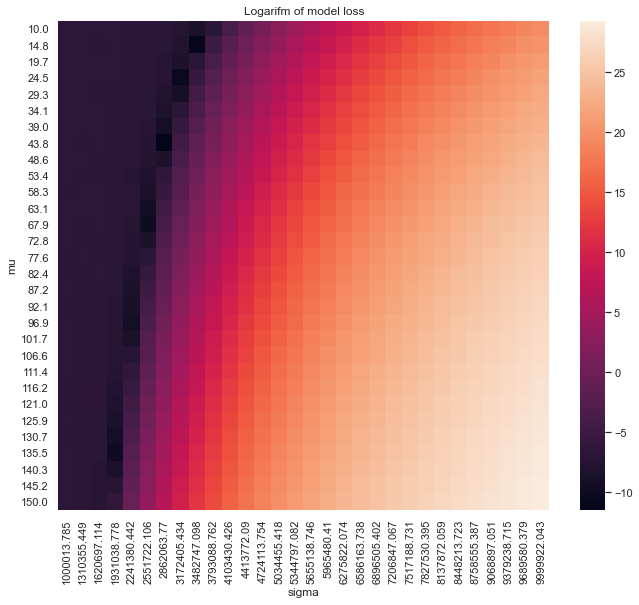

In [13]:
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(loss_model, annot=False)
name = "Logarifm of model loss"
ax.set(xlabel='sigma', ylabel='mu', title=name)
f.savefig(name + '.png', bbox_inches='tight')

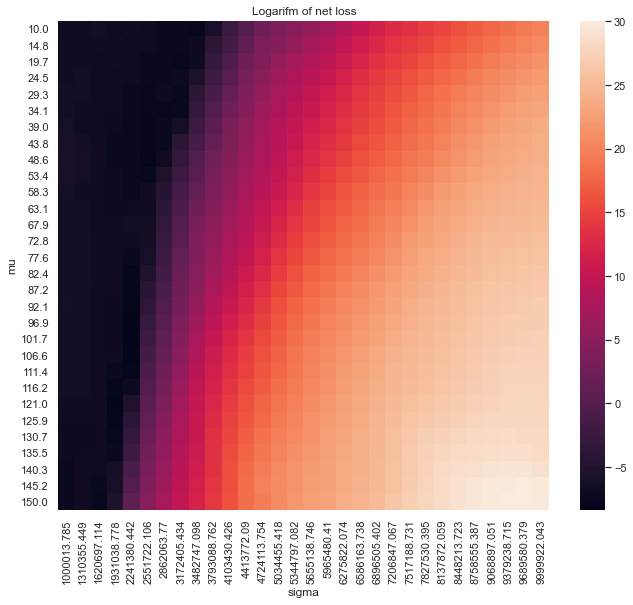

In [14]:
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(loss_net, annot=False)
name = "Logarifm of net loss"
ax.set(xlabel='sigma', ylabel='mu', title=name)
f.savefig(name + '.png', bbox_inches='tight')

### Подсчет и построение тепловой карты л2 нормы

In [16]:
sigma_norm = (sigma_real[0] - means[0]) / stds[0] 
mu_norm = (mu_real[0] - means[1]) / stds[1]
l2 = np.zeros((size, size))
i = 0
j = 0
for i in tqdm(range(size)):
    while (j < size):
        l2[i][j] = l2_norm(sigma_norm[j], mu_norm[i])
        j += 1
    j = 0
l2 = pd.DataFrame(l2)
l2.index = np.around(mu_real[0],1) 
l2.columns = np.around(sigma_real[0],3)
l2.to_pickle('./l2_matrix.pkl')
#l2 = pd.read_pickle('./l2_matrix.pkl')

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 849.97it/s]


In [17]:
l2 = pd.read_pickle('./l2_matrix.pkl')

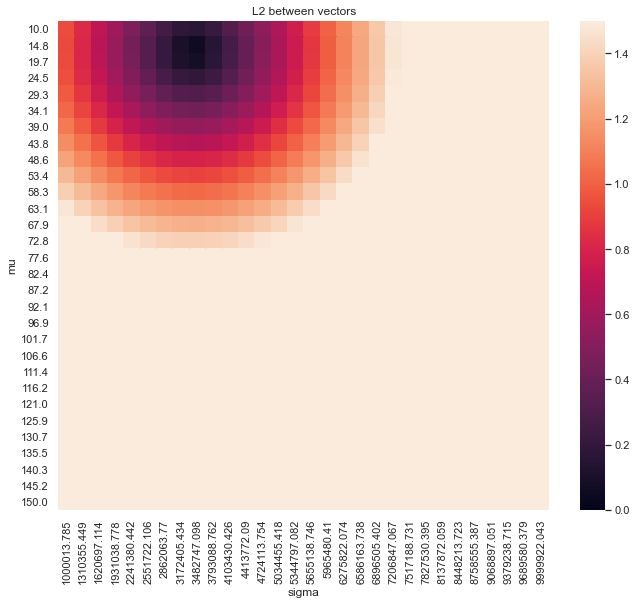

In [18]:
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(l2, annot=False, vmin=0, vmax=1.5)
name = "L2 between vectors"
ax.set(xlabel='sigma', ylabel='mu', title=name)
f.savefig(name + '.png', bbox_inches='tight')

### Взвешенная сумма -l2_norm + constant * loss_model

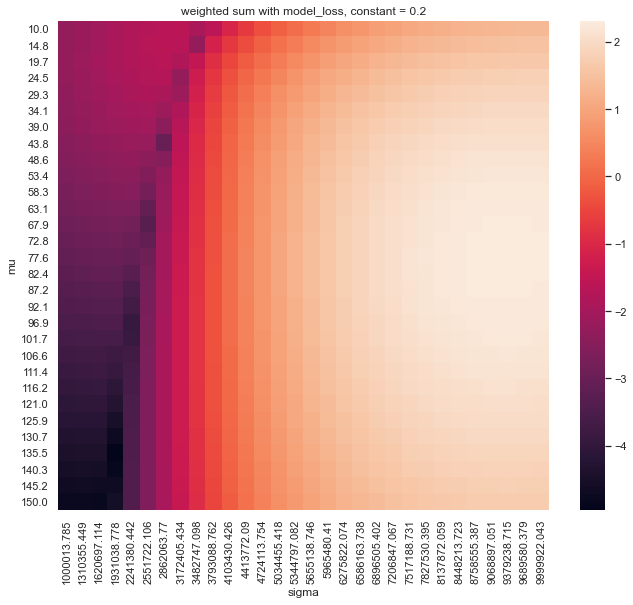

In [19]:
constant = 0.2
weighted_sum = -l2 + constant * loss_model
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(weighted_sum, annot=False)
name = "weighted sum with model_loss, constant = " + str(constant)
ax.set(xlabel='sigma', ylabel='mu', title=name)
f.savefig(name + '.png', bbox_inches='tight')

### Оптимизация model_minimization_function

In [302]:
# minimize_result_data = []
# constant = np.linspace(0.01,1,20)
# for const in tqdm(constant):
#     def model_minimization_function(variable_vector, constant=const):
#         real_sigma = variable_vector[0]
#         real_mu = variable_vector[1]
#         norm_sigma = (real_sigma - means[0]) / stds[0]
#         norm_mu = (real_mu - means[1]) / stds[1]
#         return (-1 * l2_norm(norm_sigma, norm_mu) + constant * model_loss(real_sigma, real_mu))   
#     x0 = np.array([fix_real_vector.get('Sigma').iloc[0],fix_real_vector.get('mu').iloc[0]])
#     res =  minimize(model_minimization_function, x0, method='SLSQP', bounds=((sigma_min[0][0] * stds[0] + means[0], 
#                                                                     sigma_max[0][0] * stds[0] + means[0]),
#                                                                    (mu_min[0][0] * stds[1] + means[1],
#                                                                     mu_max[0][0] * stds[1] + means[1])),options={'disp': False,
#                                                                                                                 'maxiter':1e6,
#                                                                                                                 'ftol':1e-9,
#                                                                                                                 'eps': 0.1})
#     minimize_result_data.append({'l2_norm': l2_norm((res.x[0] - means[0]) / stds[0], (res.x[1] - means[1]) / stds[1]),
#                                  'log_loss': model_loss(res.x[0], res.x[1]),
#                                  'loss': np.exp(model_loss(res.x[0], res.x[1])),
#                                  'constant': const, 'data': res.x, 'message': res.message})
# minimize_result_data = pd.DataFrame(minimize_result_data)
# minimize_result_data
# #print(res)

#### Оптимизация функции нормированных величин

## SLSQP

In [303]:
# minimize_result_data = []
# constant = np.linspace(0.001,0.2,20)
# for const in tqdm(constant):
#     def model_minimization_function(norm_variable_vector, constant=const):
#         real_sigma = norm_variable_vector[0] * stds[0] + means[0]
#         real_mu = norm_variable_vector[1] * stds[1] + means[1]
#         norm_sigma = norm_variable_vector[0]
#         norm_mu = norm_variable_vector[1]
#         return (-1 * l2_norm(norm_sigma, norm_mu) + constant * model_loss(real_sigma, real_mu))   
#     x0 = np.array([fix_normed_vector.get('Sigma').iloc[0],fix_normed_vector.get('mu').iloc[0]])
#     res =  minimize(model_minimization_function, x0, method='SLSQP', bounds=((norm_min_sigma, norm_max_sigma),
#                                                                              (norm_min_mu, norm_max_mu)),options={'disp': False,
#                                                                                                                 'maxiter':1e6,
#                                                                                                                 'ftol':1e-9,
#                                                                                                                 })
#     minimize_result_data.append({'l2_norm': l2_norm(res.x[0], res.x[1]),
#                                  'log_loss': model_loss(res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1]),
#                                  'loss': np.exp(model_loss(res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1])),
#                                  'constant': const, 'data': (res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1]),
#                                  'message': res.message})
# minimize_result_data_2 = pd.DataFrame(minimize_result_data)
# minimize_result_data_2

In [212]:
def callbackF(xk):
    print ('there is xk', [xk[0] * stds[0] + means[0], xk[1] * stds[1] + means[1]])
minimize_result_data = []
constant = np.linspace(1e-05,1e-03,3)
for const in tqdm(constant):
    def model_minimization_function(norm_variable_vector, constant=const):
        real_sigma = norm_variable_vector[0] * stds[0] + means[0]
        real_mu = norm_variable_vector[1] * stds[1] + means[1]
        norm_sigma = norm_variable_vector[0]
        norm_mu = norm_variable_vector[1]
        return 1e-04*(-1 * l2_norm(norm_sigma, norm_mu) + constant * model_loss(real_sigma, real_mu))   
    x0 = np.array([fix_normed_vector.get('Sigma').iloc[0],fix_normed_vector.get('mu').iloc[0]])
    res =  minimize(model_minimization_function, x0, method='SLSQP',
                    callback=callbackF
                    ,bounds=((norm_min_sigma, norm_max_sigma),
                                                                             (norm_min_mu, norm_max_mu)),options={'disp': False,
                                                                                                                'maxiter':1e6,
                                                                                                                'ftol':1e-9,
                                                                                                                })
    minimize_result_data.append({'l2_norm': l2_norm(res.x[0], res.x[1]),
                                 'log_loss': model_loss(res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1]),
                                 'loss': np.exp(model_loss(res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1])),
                                 'constant': const, 'data': (res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1]),
                                 'message': res.message})
minimize_result_data_2 = pd.DataFrame(minimize_result_data)
minimize_result_data_2

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

there is xk [1000013.7854274483, 10.001820859598737]
there is xk [1000013.7854274483, 35.919672178876645]
there is xk [3398940.4318024255, 16.64569892728867]
there is xk [3422411.9992910493, 16.45251448501613]
there is xk [3398221.6017089323, 16.650830831144702]
there is xk [3415779.056214948, 17.034184905843176]
there is xk [3499724.2548242575, 18.86716658876243]
there is xk [3398269.933069493, 16.65185897688969]
there is xk [3397798.999754551, 16.641468817470226]
there is xk [3398321.364695725, 16.652984244155725]


 33%|███████████████████████████▋                                                       | 1/3 [03:08<06:16, 188.23s/it]

there is xk [1000013.7854274483, 10.001820859598737]
there is xk [3785287.1078435257, 10.001832050323273]
there is xk [3624244.5849256394, 12.096220942113192]
there is xk [3727587.1234645755, 10.001820859598737]
there is xk [3401532.8415829847, 16.612541842422075]
there is xk [3401440.639196604, 16.61442760818973]
there is xk [3401519.302482974, 16.61386298708213]
there is xk [3401438.0194813926, 16.61444713367164]
there is xk [3401437.8250309564, 16.614447731368557]
there is xk [3401437.983770986, 16.614447124473486]


 67%|███████████████████████████████████████████████████████▎                           | 2/3 [06:01<03:03, 183.61s/it]

there is xk [1002088.514781828, 10.036974008897062]
there is xk [3802796.0618138826, 10.001820859598737]
there is xk [3358332.4312869273, 17.969185159893016]
there is xk [3400827.159253879, 16.626633953831274]
there is xk [3398853.700614673, 16.600326610048086]
there is xk [3400899.52632278, 16.626345191023916]
there is xk [3401330.401886642, 16.62030521818351]
there is xk [3400876.6794744874, 16.62664562339912]


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [08:59<00:00, 179.91s/it]


,l2_norm,log_loss,loss,constant,data,message
0,0.001796,-10.807173,0.000020,0.010,"(3398321.303829564, 16.652980340783387)",Optimization terminated successfully
1,0.000809,-9.935222,0.000048,0.255,"(3401437.982616104, 16.614447246975345)",Optimization terminated successfully
2,0.000823,-11.726306,0.000008,0.500,"(3400876.7590660416, 16.62665150040842)",Optimization terminated successfully


## Trust-Constr

In [28]:
# def callbackF(xk, result):
#     print ('there is xk', [xk[0] * stds[0] + means[0], xk[1] * stds[1] + means[1]])
# minimize_result_data = []
# constant = np.linspace(1e-03,1e-02,4)
# for const in tqdm(constant):
#     def model_minimization_function(norm_variable_vector, constant=const):
#         real_sigma = norm_variable_vector[0] * stds[0] + means[0]
#         real_mu = norm_variable_vector[1] * stds[1] + means[1]
#         norm_sigma = norm_variable_vector[0]
#         norm_mu = norm_variable_vector[1]
#         return (-1 * l2_norm(norm_sigma, norm_mu) + constant * model_loss(real_sigma, real_mu))  
#     x0 = np.array([fix_normed_vector.get('Sigma').iloc[0],fix_normed_vector.get('mu').iloc[0]])
#     res =  minimize(model_minimization_function, x0, method='trust-constr', callback=None,bounds=((norm_min_sigma,norm_max_sigma),
#                                                                    (norm_min_mu,norm_max_mu))
#                     ,options={'disp': False,
#                              })
#     minimize_result_data.append({'l2_norm': l2_norm(res.x[0], res.x[1]),
#                                  'log_loss': model_loss(res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1]),
#                                  'loss': np.exp(model_loss(res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1])),
#                                  'constant': const, 'data': (res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1]),
#                                  'message': res.message})
# minimize_result_data_3 = pd.DataFrame(minimize_result_data)
# minimize_result_data_3

In [33]:
history_train_1 = []
def callbackF(xk, result):
    history_train_1.append({'sigma': xk[0] * stds[0] + means[0],
                   'mu':xk[1] * stds[1] + means[1]})
    #print ('there is xk', [xk[0] * stds[0] + means[0], xk[1] * stds[1] + means[1]])
minimize_result_data = []
constant = np.array([0.2])
for const in tqdm(constant):
    def model_minimization_function(norm_variable_vector, constant=const):
        real_sigma = norm_variable_vector[0] * stds[0] + means[0]
        real_mu = norm_variable_vector[1] * stds[1] + means[1]
        norm_sigma = norm_variable_vector[0]
        norm_mu = norm_variable_vector[1]
        return (-1 * l2_norm(norm_sigma, norm_mu) + constant * model_loss(real_sigma, real_mu))  
    x0 = np.array([fix_normed_vector.get('Sigma').iloc[0],fix_normed_vector.get('mu').iloc[0]])
    res =  minimize(model_minimization_function, x0, method='trust-constr', callback=callbackF,bounds=((norm_min_sigma,norm_max_sigma),
                                                                   (norm_min_mu,norm_max_mu))
                    ,options={'disp': False,
                             })
    minimize_result_data.append({'l2_norm': l2_norm(res.x[0], res.x[1]),
                                 'log_loss': model_loss(res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1]),
                                 'loss': np.exp(model_loss(res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1])),
                                 'constant': const, 'data': (res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1]),
                                 'message': res.message})
minimize_result_data_train_1 = pd.DataFrame(minimize_result_data)
minimize_result_data_train_1

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [07:37<00:00, 457.60s/it]


,l2_norm,log_loss,loss,constant,data,message
0,0.712167,-7.499398,0.000553,0.2,"(2967951.238072647, 44.60806897651659)",`xtol` termination condition is satisfied.


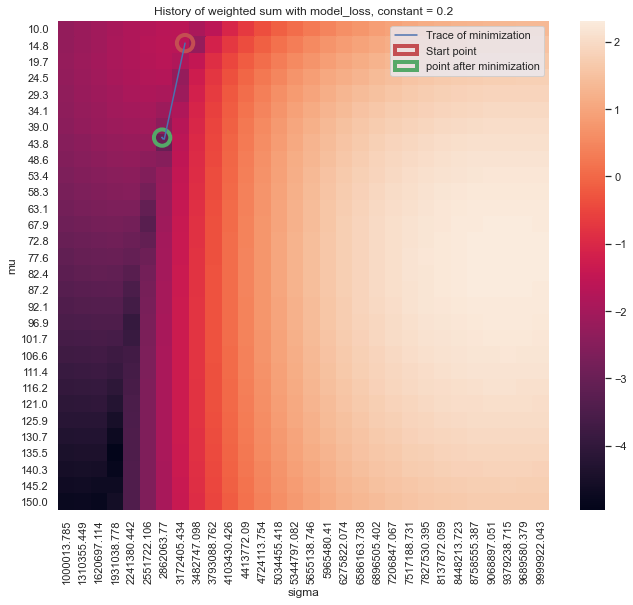

In [34]:
real_sigma_new = minimize_result_data_train_1.iloc[0]['data'][0]
real_mu_new = minimize_result_data_train_1.iloc[0]['data'][1]
constant = minimize_result_data_train_1.iloc[0]['constant']
sigma_history = []
mu_history = []
for i in history_train_1:
    sigma_history.append((i['sigma'] - sigma_real[0][0]) / sigma_real[1])
    mu_history.append((i['mu'] - mu_real[0][0]) / mu_real[1])
weighted_sum = -l2 + constant * loss_model
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(weighted_sum, annot=False)
name = "History of weighted sum with model_loss, constant = " + str(constant)
ax.set(xlabel='sigma', ylabel='mu', title=name)
ax = f.gca()
circle0 = plt.Circle(((fix_real_vector.get('Sigma').iloc[0] - sigma_real[0][0])/sigma_real[1],
                      (fix_real_vector.get('mu').iloc[0] - mu_real[0][0])/mu_real[1]),
                     0.5, color='r', fill=False, label="Start point", linewidth=4)
ax.add_patch(circle0)
circle1 = plt.Circle(((real_sigma_new - sigma_real[0][0])/sigma_real[1],(real_mu_new - mu_real[0][0])/mu_real[1]),
                     0.5, color='g', fill=False, label="point after minimization", linewidth=4)
ax.add_patch(circle1)
plt.plot(sigma_history, mu_history, label="Trace of minimization")
ax.legend()
f.savefig(name + '.png', bbox_inches='tight')

In [37]:
history_train_2 = []
def callbackF(xk, result):
    history_train_2.append({'sigma': xk[0] * stds[0] + means[0],
                   'mu':xk[1] * stds[1] + means[1]})
    #print ('there is xk', [xk[0] * stds[0] + means[0], xk[1] * stds[1] + means[1]])
minimize_result_data = []
# constant = np.array([0.1, 0.2, 0.5, 0.7, 1, 2, 5])
constant = np.array([0.2])
for const in tqdm(constant):
    def model_minimization_function(norm_variable_vector, constant=const):
        real_sigma = norm_variable_vector[0] * stds[0] + means[0]
        real_mu = norm_variable_vector[1] * stds[1] + means[1]
        norm_sigma = norm_variable_vector[0]
        norm_mu = norm_variable_vector[1]
        return (-1 * l2_norm(norm_sigma, norm_mu) + constant * model_loss(real_sigma, real_mu))  
    x0 = np.array([fix_normed_vector.get('Sigma').iloc[0],fix_normed_vector.get('mu').iloc[0]])
    res =  minimize(model_minimization_function, x0, method='trust-constr', callback=callbackF,bounds=((norm_min_sigma,norm_max_sigma),
                                                                   (norm_min_mu,norm_max_mu))
                    ,options={'disp': False, 'xtol':1e-10
                             })
    minimize_result_data.append({'l2_norm': l2_norm(res.x[0], res.x[1]),
                                 'log_loss': model_loss(res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1]),
                                 'loss': np.exp(model_loss(res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1])),
                                 'constant': const, 'data': (res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1]),
                                 'message': res.message})
minimize_result_data_train_2 = pd.DataFrame(minimize_result_data)
minimize_result_data_train_2

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [09:35<00:00, 575.87s/it]


,l2_norm,log_loss,loss,constant,data,message
0,0.712167,-7.499834,0.000553,0.2,"(2967951.206094197, 44.60806897651698)",`xtol` termination condition is satisfied.


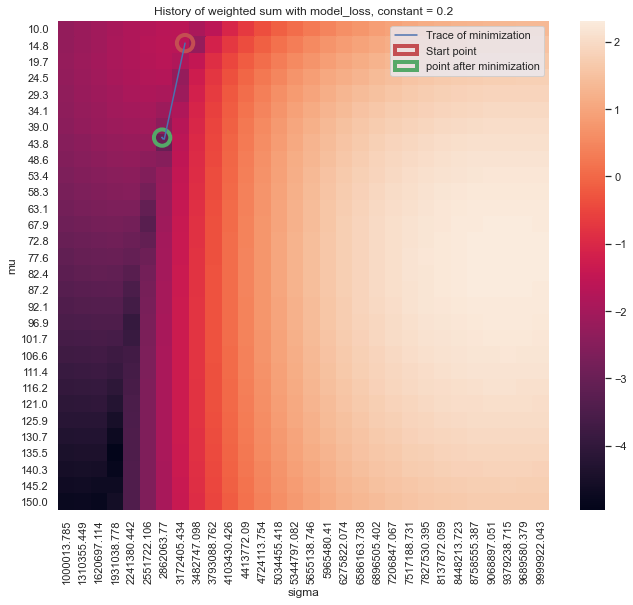

In [38]:
real_sigma_new = minimize_result_data_train_2.iloc[0]['data'][0]
real_mu_new = minimize_result_data_train_2.iloc[0]['data'][1]
constant = minimize_result_data_train_2.iloc[0]['constant']
sigma_history = []
mu_history = []
for i in history_train_2:
    sigma_history.append((i['sigma'] - sigma_real[0][0]) / sigma_real[1])
    mu_history.append((i['mu'] - mu_real[0][0]) / mu_real[1])
weighted_sum = -l2 + constant * loss_model
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(weighted_sum, annot=False)
name = "History of weighted sum with model_loss, constant = " + str(constant)
ax.set(xlabel='sigma', ylabel='mu', title=name)
ax = f.gca()
circle0 = plt.Circle(((fix_real_vector.get('Sigma').iloc[0] - sigma_real[0][0])/sigma_real[1],
                      (fix_real_vector.get('mu').iloc[0] - mu_real[0][0])/mu_real[1]),
                     0.5, color='r', fill=False, label="Start point", linewidth=4)
ax.add_patch(circle0)
circle1 = plt.Circle(((real_sigma_new - sigma_real[0][0])/sigma_real[1],(real_mu_new - mu_real[0][0])/mu_real[1]),
                     0.5, color='g', fill=False, label="point after minimization", linewidth=4)
ax.add_patch(circle1)
plt.plot(sigma_history, mu_history, label="Trace of minimization")
ax.legend()
f.savefig(name + '.png', bbox_inches='tight')

In [39]:
history_train_3 = []
def callbackF(xk, result):
    history_train_3.append({'sigma': xk[0] * stds[0] + means[0],
                   'mu':xk[1] * stds[1] + means[1]})
    #print ('there is xk', [xk[0] * stds[0] + means[0], xk[1] * stds[1] + means[1]])
minimize_result_data = []
# constant = np.array([0.1, 0.2, 0.5, 0.7, 1, 2, 5])
constant = np.array([0.2])
for const in tqdm(constant):
    def model_minimization_function(norm_variable_vector, constant=const):
        real_sigma = norm_variable_vector[0] * stds[0] + means[0]
        real_mu = norm_variable_vector[1] * stds[1] + means[1]
        norm_sigma = norm_variable_vector[0]
        norm_mu = norm_variable_vector[1]
        return (-1 * l2_norm(norm_sigma, norm_mu) + constant * model_loss(real_sigma, real_mu))  
    x0 = np.array([fix_normed_vector.get('Sigma').iloc[0],fix_normed_vector.get('mu').iloc[0]])
    res =  minimize(model_minimization_function, x0, method='trust-constr', callback=callbackF,bounds=((norm_min_sigma,norm_max_sigma),
                                                                   (norm_min_mu,norm_max_mu))
                    ,options={'disp': False, 'xtol':1e-15
                             })
    minimize_result_data.append({'l2_norm': l2_norm(res.x[0], res.x[1]),
                                 'log_loss': model_loss(res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1]),
                                 'loss': np.exp(model_loss(res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1])),
                                 'constant': const, 'data': (res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1]),
                                 'message': res.message})
minimize_result_data_train_3 = pd.DataFrame(minimize_result_data)
minimize_result_data_train_3

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [13:14<00:00, 794.43s/it]


,l2_norm,log_loss,loss,constant,data,message
0,0.712167,-7.55553,0.000523,0.2,"(2967951.2059951182, 44.60806897651628)",`xtol` termination condition is satisfied.


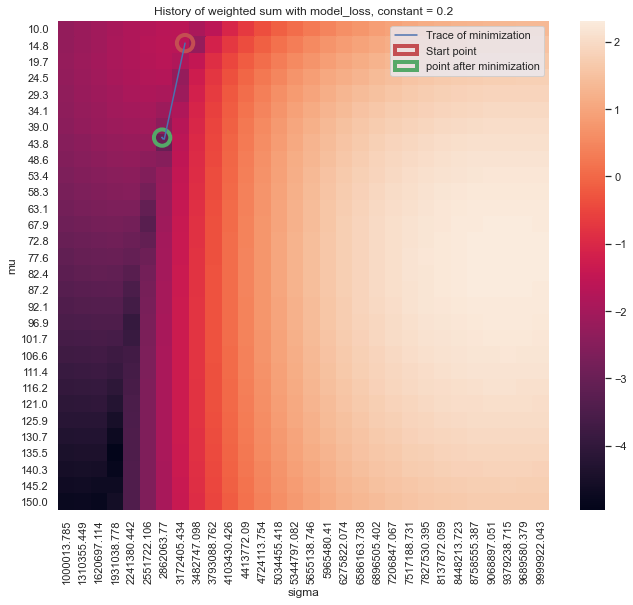

In [40]:
real_sigma_new = minimize_result_data_train_3.iloc[0]['data'][0]
real_mu_new = minimize_result_data_train_3.iloc[0]['data'][1]
constant = minimize_result_data_train_3.iloc[0]['constant']
sigma_history = []
mu_history = []
for i in history_train_3:
    sigma_history.append((i['sigma'] - sigma_real[0][0]) / sigma_real[1])
    mu_history.append((i['mu'] - mu_real[0][0]) / mu_real[1])
weighted_sum = -l2 + constant * loss_model
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(weighted_sum, annot=False)
name = "History of weighted sum with model_loss, constant = " + str(constant)
ax.set(xlabel='sigma', ylabel='mu', title=name)
ax = f.gca()
circle0 = plt.Circle(((fix_real_vector.get('Sigma').iloc[0] - sigma_real[0][0])/sigma_real[1],
                      (fix_real_vector.get('mu').iloc[0] - mu_real[0][0])/mu_real[1]),
                     0.5, color='r', fill=False, label="Start point", linewidth=4)
ax.add_patch(circle0)
circle1 = plt.Circle(((real_sigma_new - sigma_real[0][0])/sigma_real[1],(real_mu_new - mu_real[0][0])/mu_real[1]),
                     0.5, color='g', fill=False, label="point after minimization", linewidth=4)
ax.add_patch(circle1)
plt.plot(sigma_history, mu_history, label="Trace of minimization")
ax.legend()
f.savefig(name + '.png', bbox_inches='tight')

### При константе 0,2 для вектора 9030 смогли добиться значительного увеличения Л-2 нормы при относительно небольшом лоссе.

#### 1. Нарисуем спады, характерные этим константам и значением векторов

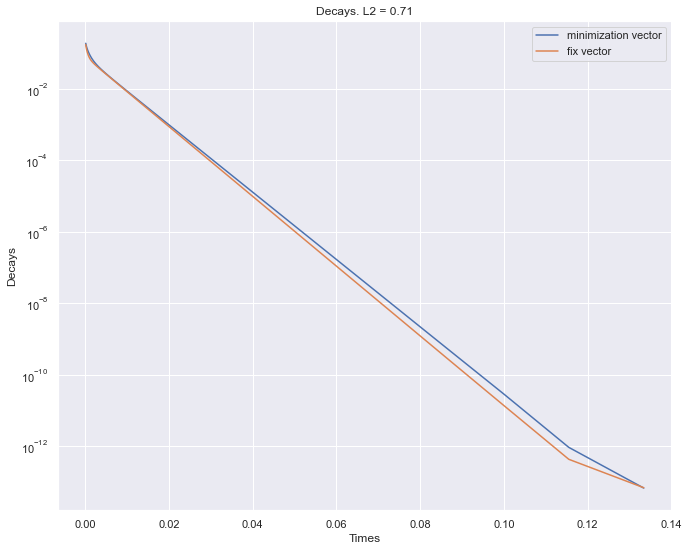

In [41]:
real_sigma_new = minimize_result_data_train_3.iloc[0]['data'][0]
real_mu_new = minimize_result_data_train_3.iloc[0]['data'][1]
f, ax = plt.subplots(figsize=(11, 9))
plt.plot(t,model_decay(sigma=real_sigma_new, mu=real_mu_new))
plt.plot(t,fix_real_vector.get('Decay').iloc[0])
plt.gca().set(xlabel='Times', ylabel='Decays')
name = 'Decays. L2 = ' + str(round(minimize_result_data_train_3.iloc[0]['l2_norm'],2))
plt.title(name)
ax.set_yscale('log')
plt.legend(labels=['minimization vector', 'fix vector'])

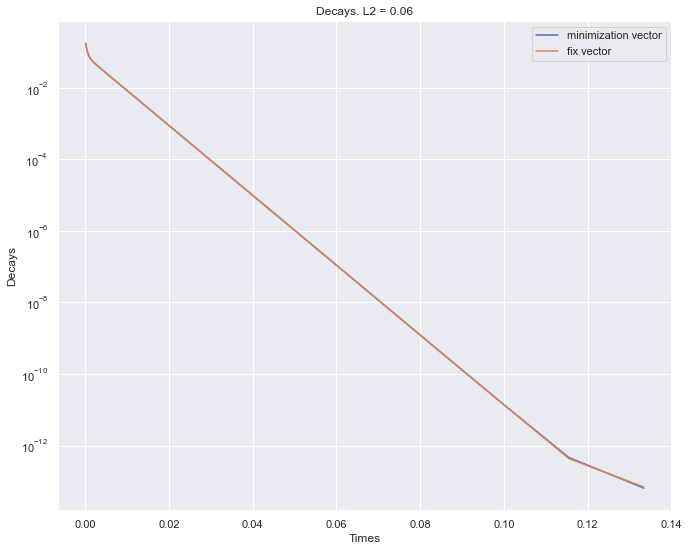

In [359]:
real_sigma_new = minimize_result_data_4.iloc[2]['data'][0]
real_mu_new = minimize_result_data_4.iloc[2]['data'][1]
f, ax = plt.subplots(figsize=(11, 9))
plt.plot(t,model_decay(sigma=real_sigma_new, mu=real_mu_new))
plt.plot(t,fix_real_vector.get('Decay').iloc[0])
plt.gca().set(xlabel='Times', ylabel='Decays')
name = 'Decays. L2 = ' + str(round(minimize_result_data_4.iloc[2]['l2_norm'],2))
plt.title(name)
ax.set_yscale('log')
plt.legend(labels=['minimization vector', 'fix vector'])

#### 2. Нарисовать зону, куда пришли. (Возможно уже устарело)

In [260]:
# ## Потом убрать 
# sigma_real = np.linspace(min_sigma, max_sigma, num=size, retstep=True)#sigma
# mu_real = np.linspace(min_mu, max_mu, num=size, retstep=True)#mu

1000013.7854274483

In [340]:
# history = []
# def callbackF(xk, result):
#     history.append({'sigma': xk[0] * stds[0] + means[0],
#                    'mu':xk[1] * stds[1] + means[1]})
#     #print ('there is xk', [xk[0] * stds[0] + means[0], xk[1] * stds[1] + means[1]])
# minimize_result_data = []
# constant = np.array([minimize_result_data_4.iloc[0]['constant']])
# for const in tqdm(constant):
#     def model_minimization_function(norm_variable_vector, constant=const):
#         real_sigma = norm_variable_vector[0] * stds[0] + means[0]
#         real_mu = norm_variable_vector[1] * stds[1] + means[1]
#         norm_sigma = norm_variable_vector[0]
#         norm_mu = norm_variable_vector[1]
#         return (-1 * l2_norm(norm_sigma, norm_mu) + constant * model_loss(real_sigma, real_mu))  
#     x0 = np.array([fix_normed_vector.get('Sigma').iloc[0],fix_normed_vector.get('mu').iloc[0]])
#     res =  minimize(model_minimization_function, x0, method='trust-constr', callback=callbackF,bounds=((norm_min_sigma,norm_max_sigma),
#                                                                    (norm_min_mu,norm_max_mu))
#                     ,options={'disp': False,
#                              })
#     minimize_result_data.append({'l2_norm': l2_norm(res.x[0], res.x[1]),
#                                  'log_loss': model_loss(res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1]),
#                                  'loss': np.exp(model_loss(res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1])),
#                                  'constant': const, 'data': (res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1]),
#                                  'message': res.message})
# minimize_result_data_5 = pd.DataFrame(minimize_result_data)
# minimize_result_data_5

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [18:20<00:00, 1100.48s/it]


,l2_norm,log_loss,loss,constant,data,message
0,0.898061,-11.003899,0.000017,0.1,"(2722502.561642618, 51.34362107846994)",`xtol` termination condition is satisfied.


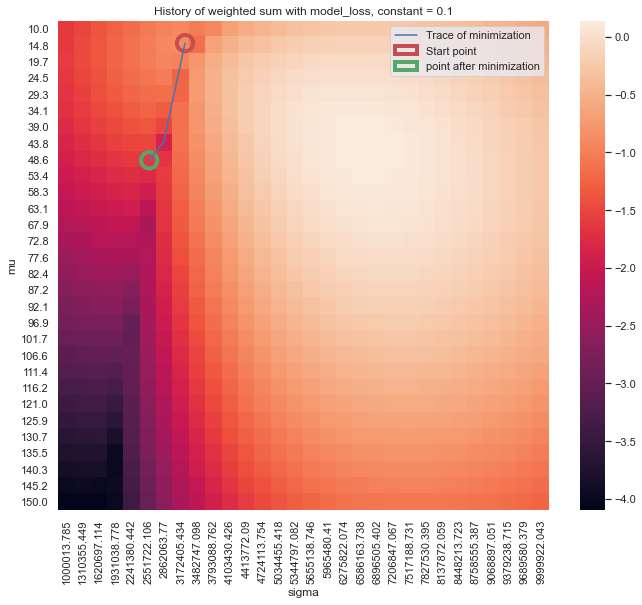

In [341]:
# real_sigma_new = minimize_result_data_5.iloc[0]['data'][0]
# real_mu_new = minimize_result_data_5.iloc[0]['data'][1]
# constant = minimize_result_data_5.iloc[0]['constant']
# sigma_history = []
# mu_history = []
# for i in history:
#     sigma_history.append((i['sigma'] - sigma_real[0][0]) / sigma_real[1])
#     mu_history.append((i['mu'] - mu_real[0][0]) / mu_real[1])
# weighted_sum = -l2 + constant * loss_model
# f, ax = plt.subplots(figsize=(11, 9))
# sns.heatmap(weighted_sum, annot=False)
# name = "History of weighted sum with model_loss, constant = " + str(constant)
# ax.set(xlabel='sigma', ylabel='mu', title=name)
# ax = f.gca()
# circle0 = plt.Circle(((fix_real_vector.get('Sigma').iloc[0] - sigma_real[0][0])/sigma_real[1],
#                       (fix_real_vector.get('mu').iloc[0] - mu_real[0][0])/mu_real[1]),
#                      0.5, color='r', fill=False, label="Start point", linewidth=4)
# ax.add_patch(circle0)
# circle1 = plt.Circle(((real_sigma_new - sigma_real[0][0])/sigma_real[1],(real_mu_new - mu_real[0][0])/mu_real[1]),
#                      0.5, color='g', fill=False, label="point after minimization", linewidth=4)
# ax.add_patch(circle1)
# plt.plot(sigma_history, mu_history, label="Trace of minimization")
# ax.legend()
# f.savefig(name + '.png', bbox_inches='tight')

In [342]:
# history = []
# def callbackF(xk, result):
#     history.append({'sigma': xk[0] * stds[0] + means[0],
#                    'mu':xk[1] * stds[1] + means[1]})
#     #print ('there is xk', [xk[0] * stds[0] + means[0], xk[1] * stds[1] + means[1]])
# minimize_result_data = []
# constant = np.array([minimize_result_data_4.iloc[2]['constant']])
# for const in tqdm(constant):
#     def model_minimization_function(norm_variable_vector, constant=const):
#         real_sigma = norm_variable_vector[0] * stds[0] + means[0]
#         real_mu = norm_variable_vector[1] * stds[1] + means[1]
#         norm_sigma = norm_variable_vector[0]
#         norm_mu = norm_variable_vector[1]
#         return (-1 * l2_norm(norm_sigma, norm_mu) + constant * model_loss(real_sigma, real_mu))  
#     x0 = np.array([fix_normed_vector.get('Sigma').iloc[0],fix_normed_vector.get('mu').iloc[0]])
#     res =  minimize(model_minimization_function, x0, method='trust-constr', callback=callbackF,bounds=((norm_min_sigma,norm_max_sigma),
#                                                                    (norm_min_mu,norm_max_mu))
#                     ,options={'disp': False,
#                              })
#     minimize_result_data.append({'l2_norm': l2_norm(res.x[0], res.x[1]),
#                                  'log_loss': model_loss(res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1]),
#                                  'loss': np.exp(model_loss(res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1])),
#                                  'constant': const, 'data': (res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1]),
#                                  'message': res.message})
# minimize_result_data_6 = pd.DataFrame(minimize_result_data)
# minimize_result_data_6

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [06:49<00:00, 409.82s/it]


,l2_norm,log_loss,loss,constant,data,message
0,0.057997,-12.488134,0.000004,0.5,"(3467113.5268488093, 14.519950869112606)",`xtol` termination condition is satisfied.


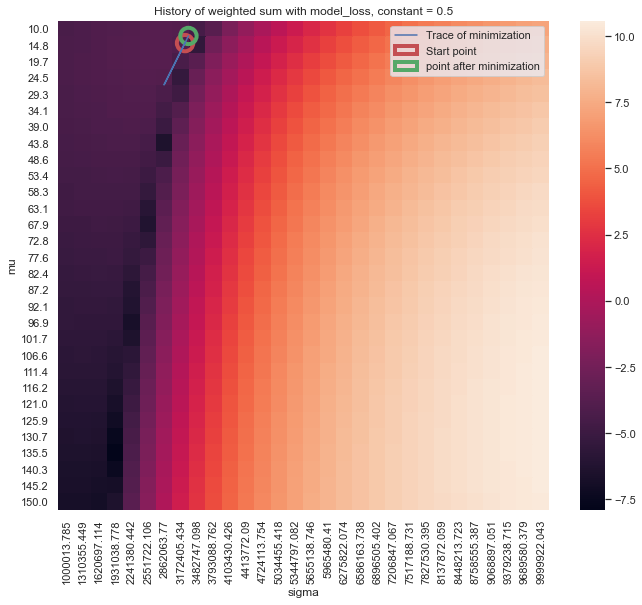

In [343]:
# real_sigma_new = minimize_result_data_6.iloc[0]['data'][0]
# real_mu_new = minimize_result_data_6.iloc[0]['data'][1]
# constant = minimize_result_data_6.iloc[0]['constant']
# sigma_history = []
# mu_history = []
# for i in history:
#     sigma_history.append((i['sigma'] - sigma_real[0][0]) / sigma_real[1])
#     mu_history.append((i['mu'] - mu_real[0][0]) / mu_real[1])
# weighted_sum = -l2 + constant * loss_model
# f, ax = plt.subplots(figsize=(11, 9))
# sns.heatmap(weighted_sum, annot=False)
# name = "History of weighted sum with model_loss, constant = " + str(constant)
# ax.set(xlabel='sigma', ylabel='mu', title=name)
# ax = f.gca()
# circle0 = plt.Circle(((fix_real_vector.get('Sigma').iloc[0] - sigma_real[0][0])/sigma_real[1],
#                       (fix_real_vector.get('mu').iloc[0] - mu_real[0][0])/mu_real[1]),
#                      0.5, color='r', fill=False, label="Start point", linewidth=4)
# ax.add_patch(circle0)
# circle1 = plt.Circle(((real_sigma_new - sigma_real[0][0])/sigma_real[1],(real_mu_new - mu_real[0][0])/mu_real[1]),
#                      0.5, color='g', fill=False, label="point after minimization", linewidth=4)
# ax.add_patch(circle1)
# plt.plot(sigma_history, mu_history, label="Trace of minimization")
# ax.legend()
# f.savefig(name + '.png', bbox_inches='tight')

### Пробуем нейросетевой подход

In [350]:
def callbackF(xk, result):
    print ('there is xk', [xk[0] * stds[0] + means[0], xk[1] * stds[1] + means[1]])
minimize_result_data = []
constant = np.array([0.2])
#constant = np.linspace(1e-03,0.5,10)
for const in tqdm(constant):
    def model_minimization_function(norm_variable_vector, constant=const):
        real_sigma = norm_variable_vector[0] * stds[0] + means[0]
        real_mu = norm_variable_vector[1] * stds[1] + means[1]
        norm_sigma = norm_variable_vector[0]
        norm_mu = norm_variable_vector[1]
        return (-1 * l2_norm(norm_sigma, norm_mu) + constant * net_loss(norm_sigma, norm_mu))  
    x0 = np.array([fix_normed_vector.get('Sigma').iloc[0],fix_normed_vector.get('mu').iloc[0]])
    res =  minimize(model_minimization_function, x0, method='trust-constr', callback=None,bounds=((norm_min_sigma,norm_max_sigma),
                                                                   (norm_min_mu,norm_max_mu))
                    ,options={'disp': False,
                             })
    minimize_result_data.append({'l2_norm': l2_norm(res.x[0], res.x[1]),
                                 'log_loss': model_loss(res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1]),
                                 'loss': np.exp(model_loss(res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1])),
                                 'constant': const, 'data': (res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1]),
                                 'message': res.message})
minimize_result_data_net = pd.DataFrame(minimize_result_data)
minimize_result_data_net

 10%|████████▎                                                                          | 1/10 [00:03<00:33,  3.74s/it]C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:40<00:00,  4.03s/it]


,l2_norm,log_loss,loss,constant,data,message
0,3.427600,-6.733456,0.001190,0.001000,"(1001443.2217417704, 149.99307401129636)",`gtol` termination condition is satisfied.
1,3.427731,-6.748185,0.001173,0.056444,"(1000530.7323607709, 149.99457518810618)",`gtol` termination condition is satisfied.
2,3.358586,-7.854309,0.000388,0.111889,"(1726724.0916710328, 149.83037321861977)",`xtol` termination condition is satisfied.
3,3.427795,-6.760200,0.001159,0.167333,"(1000478.8056935426, 149.9970356549817)",`gtol` termination condition is satisfied.
4,3.362732,-7.816392,0.000403,0.222778,"(1724684.1040182896, 149.9949119333353)",`xtol` termination condition is satisfied.
5,3.355896,-7.885832,0.000376,0.278222,"(1728047.0550431418, 149.72366972645239)",`xtol` termination condition is satisfied.
6,1.104317,-6.654620,0.001288,0.333667,"(1444302.2497706981, 49.13425216435971)",`xtol` termination condition is satisfied.
7,3.393834,-6.744502,0.001177,0.389111,"(1265919.5960479043, 149.68022288974225)",`xtol` termination condition is satisfied.
8,3.427762,-6.696027,0.001236,0.444556,"(1000815.8133141417, 149.99712045621382)",`gtol` termination condition is satisfied.
9,3.359047,-7.608714,0.000496,0.500000,"(1726497.2667401675, 149.84866990427673)",`xtol` termination condition is satisfied.


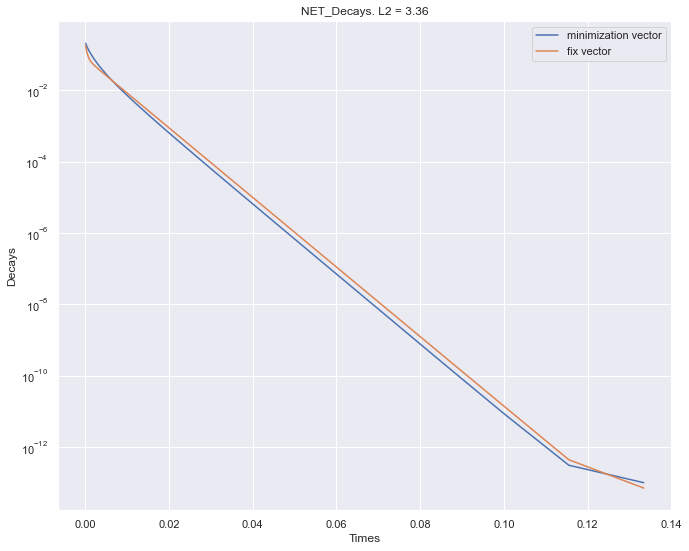

In [357]:
real_sigma_new = minimize_result_data_net.iloc[5]['data'][0]
real_mu_new = minimize_result_data_net.iloc[5]['data'][1]
f, ax = plt.subplots(figsize=(11, 9))
plt.plot(t,model_decay(sigma=real_sigma_new, mu=real_mu_new))
plt.plot(t,fix_real_vector.get('Decay').iloc[0])
plt.gca().set(xlabel='Times', ylabel='Decays')
name = 'NET_Decays. L2 = ' + str(round(minimize_result_data_net.iloc[5]['l2_norm'],2))
plt.title(name)
ax.set_yscale('log')
plt.legend(labels=['minimization vector', 'fix vector'])

In [74]:
history_net = []
def callbackF(xk, result):
    history_net.append({'sigma': xk[0] * stds[0] + means[0],
                   'mu':xk[1] * stds[1] + means[1]})
    #print ('there is xk', [xk[0] * stds[0] + means[0], xk[1] * stds[1] + means[1]])
minimize_result_data = []
#constant = np.array([minimize_result_data_net.iloc[5]['constant']])
constant =  np.array([0.2])
for const in tqdm(constant):
    def model_minimization_function(norm_variable_vector, constant=const):
        real_sigma = norm_variable_vector[0] * stds[0] + means[0]
        real_mu = norm_variable_vector[1] * stds[1] + means[1]
        norm_sigma = norm_variable_vector[0]
        norm_mu = norm_variable_vector[1]
        return (-1 * l2_norm(norm_sigma, norm_mu) + constant * net_loss(norm_sigma, norm_mu))  
    x0 = np.array([fix_normed_vector.get('Sigma').iloc[0],fix_normed_vector.get('mu').iloc[0]])
    res =  minimize(model_minimization_function, x0, method='trust-constr', callback=callbackF,bounds=((norm_min_sigma,norm_max_sigma),
                                                                   (norm_min_mu,norm_max_mu))
                    ,options={'disp': False, 'xtol':1e-15, 'initial_constr_penalty': 0.1,
                              'maxiter':1e5, 'initial_tr_radius': 0.5
                             })
    minimize_result_data.append({'l2_norm': l2_norm(res.x[0], res.x[1]),
                                 'log_loss': model_loss(res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1]),
                                 'loss': np.exp(model_loss(res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1])),
                                 'constant': const, 'data': (res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1]),
                                 'message': res.message})
minimize_result_data_7 = pd.DataFrame(minimize_result_data)
minimize_result_data_7

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.88s/it]


,l2_norm,log_loss,loss,constant,data,message
0,3.3624,-7.10934,0.000817,0.2,"(1594314.2360333973, 149.5646430002551)",`xtol` termination condition is satisfied.


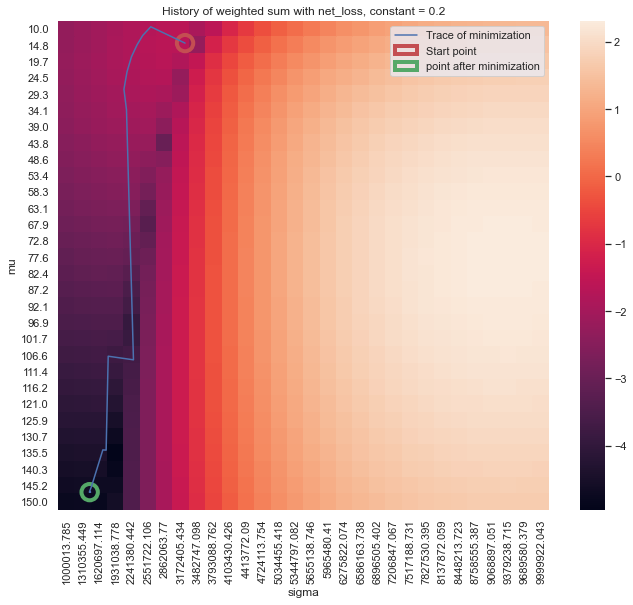

In [75]:
real_sigma_new = minimize_result_data_7.iloc[0]['data'][0]
real_mu_new = minimize_result_data_7.iloc[0]['data'][1]
#constant = minimize_result_data_7.iloc[0]['constant']
constant = 0.2
sigma_history = []
mu_history = []
for i in history_net:
    sigma_history.append((i['sigma'] - sigma_real[0][0]) / sigma_real[1])
    mu_history.append((i['mu'] - mu_real[0][0]) / mu_real[1])
weighted_sum = -l2 + constant * loss_model
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(weighted_sum, annot=False)
name = "History of weighted sum with net_loss, constant = " + str(constant)
ax.set(xlabel='sigma', ylabel='mu', title=name)
ax = f.gca()
circle0 = plt.Circle(((fix_real_vector.get('Sigma').iloc[0] - sigma_real[0][0])/sigma_real[1],
                      (fix_real_vector.get('mu').iloc[0] - mu_real[0][0])/mu_real[1]),
                     0.5, color='r', fill=False, label="Start point", linewidth=4)
ax.add_patch(circle0)
circle1 = plt.Circle(((real_sigma_new - sigma_real[0][0])/sigma_real[1],(real_mu_new - mu_real[0][0])/mu_real[1]),
                     0.5, color='g', fill=False, label="point after minimization", linewidth=4)
ax.add_patch(circle1)
plt.plot(sigma_history, mu_history, label="Trace of minimization")
ax.legend()
f.savefig(name + '.png', bbox_inches='tight')

### Пробуем БФГС для сетки

In [83]:
history_net_bfgs = []
def callbackF(xk):
    print({'sigma': xk[0] * stds[0] + means[0],
                   'mu':xk[1] * stds[1] + means[1]})
    history_net_bfgs.append({'sigma': xk[0] * stds[0] + means[0],
                   'mu':xk[1] * stds[1] + means[1]})
    #print ('there is xk', [xk[0] * stds[0] + means[0], xk[1] * stds[1] + means[1]])
minimize_result_data = []
#constant = np.array([minimize_result_data_net.iloc[5]['constant']])
constant =  np.array([0.2])
for const in tqdm(constant):
    def model_minimization_function(norm_variable_vector, constant=const):
        real_sigma = norm_variable_vector[0] * stds[0] + means[0]
        real_mu = norm_variable_vector[1] * stds[1] + means[1]
        norm_sigma = norm_variable_vector[0]
        norm_mu = norm_variable_vector[1]
        return (-1 * l2_norm(norm_sigma, norm_mu) + constant * net_loss(norm_sigma, norm_mu))  
    x0 = np.array([fix_normed_vector.get('Sigma').iloc[0],fix_normed_vector.get('mu').iloc[0]])
    res =  minimize(model_minimization_function, x0, method='L-BFGS-B', callback=callbackF,bounds=((norm_min_sigma,norm_max_sigma),
                                                                   (norm_min_mu,norm_max_mu))
                    ,options={'disp': False, 'gtol': 1e-20, 
                             })
    minimize_result_data.append({'l2_norm': l2_norm(res.x[0], res.x[1]),
                                 'log_loss': model_loss(res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1]),
                                 'loss': np.exp(model_loss(res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1])),
                                 'constant': const, 'data': (res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1]),
                                 'message': res.message})
minimize_result_data_bfgs = pd.DataFrame(minimize_result_data)
minimize_result_data_bfgs

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

{'sigma': 3385502.113664759, 'mu': 24.73601639992151}
{'sigma': 3309044.2859699475, 'mu': 26.293189625727294}
{'sigma': 2740172.214427042, 'mu': 51.095271106162286}
{'sigma': 1000013.7854274483, 'mu': 124.49185618504222}
{'sigma': 1000013.7854274483, 'mu': 128.0580335120474}
{'sigma': 1000013.7854274483, 'mu': 149.9983173491276}


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.13s/it]


,l2_norm,log_loss,loss,constant,data,message
0,3.427874,-6.677654,0.001259,0.2,"(1000013.7854274483, 149.9983173491276)",b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_P...


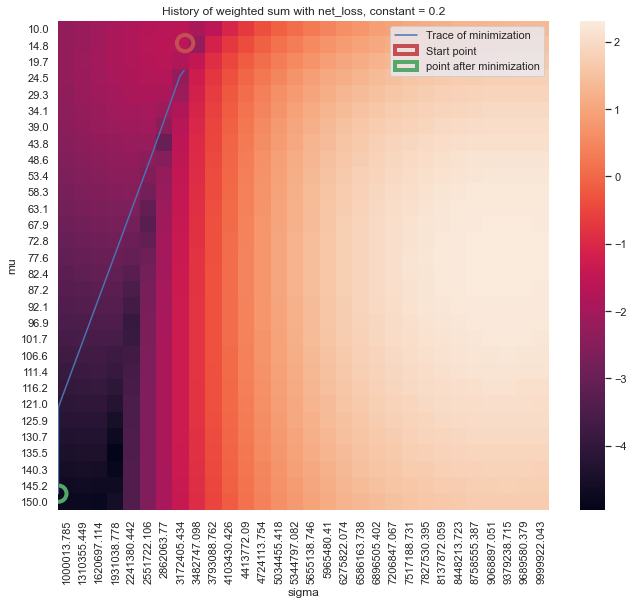

In [84]:
real_sigma_new = minimize_result_data_bfgs.iloc[0]['data'][0]
real_mu_new = minimize_result_data_bfgs.iloc[0]['data'][1]
#constant = minimize_result_data_7.iloc[0]['constant']
constant = 0.2
sigma_history = []
mu_history = []
for i in history_net_bfgs:
    sigma_history.append((i['sigma'] - sigma_real[0][0]) / sigma_real[1])
    mu_history.append((i['mu'] - mu_real[0][0]) / mu_real[1])
weighted_sum = -l2 + constant * loss_model
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(weighted_sum, annot=False)
name = "History of weighted sum with net_loss, constant = " + str(constant)
ax.set(xlabel='sigma', ylabel='mu', title=name)
ax = f.gca()
circle0 = plt.Circle(((fix_real_vector.get('Sigma').iloc[0] - sigma_real[0][0])/sigma_real[1],
                      (fix_real_vector.get('mu').iloc[0] - mu_real[0][0])/mu_real[1]),
                     0.5, color='r', fill=False, label="Start point", linewidth=4)
ax.add_patch(circle0)
circle1 = plt.Circle(((real_sigma_new - sigma_real[0][0])/sigma_real[1],(real_mu_new - mu_real[0][0])/mu_real[1]),
                     0.5, color='g', fill=False, label="point after minimization", linewidth=4)
ax.add_patch(circle1)
plt.plot(sigma_history, mu_history, label="Trace of minimization")
ax.legend()
f.savefig(name + '.png', bbox_inches='tight')

[]